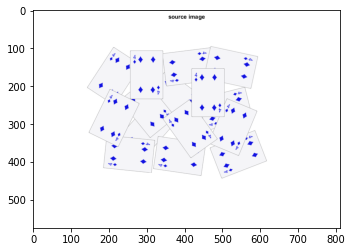

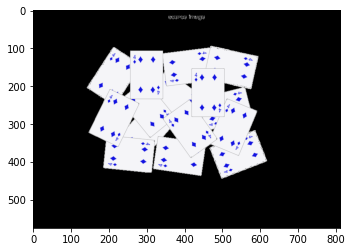

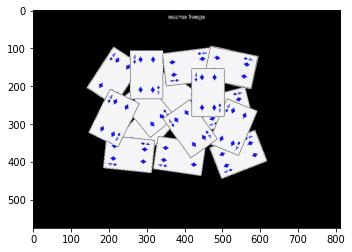

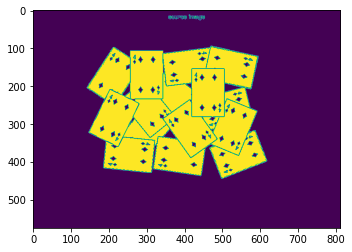

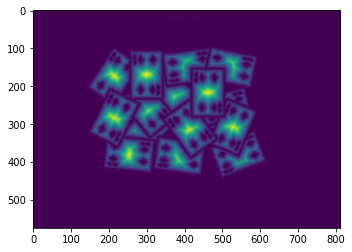

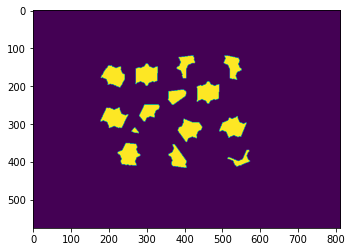

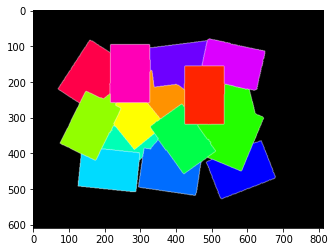

In [30]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
import random as rng
from matplotlib import pyplot as plt
rng.seed(12345)
src = cv.imread("cards.png")
if src is None:
    print('Could not open or find the image:', args.input)
    exit(0)
# Show source image
plt.imshow(src)
plt.show()
src[np.all(src == 255, axis=2)] = 0
# Show output image
plt.imshow(src)
plt.show()
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
# do the laplacian filtering as it is
# well, we need to convert everything in something more deeper then CV_8U
# because the kernel has some negative values,
# and we can expect in general to have a Laplacian image with negative values
# BUT a 8bits unsigned int (the one we are working with) can contain values from 0 to 255
# so the possible negative number will be truncated
imgLaplacian = cv.filter2D(src, cv.CV_32F, kernel)
sharp = np.float32(src)
imgResult = sharp - imgLaplacian
# convert back to 8bits gray scale
imgResult = np.clip(imgResult, 0, 255)
imgResult = imgResult.astype('uint8')
imgLaplacian = np.clip(imgLaplacian, 0, 255)
imgLaplacian = np.uint8(imgLaplacian)
#cv.imshow('Laplace Filtered Image', imgLaplacian)
plt.imshow(imgResult)
plt.show()
bw = cv.cvtColor(imgResult, cv.COLOR_BGR2GRAY)
_, bw = cv.threshold(bw, 40, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
plt.imshow(bw)
plt.show()
dist = cv.distanceTransform(bw, cv.DIST_L2, 3)
# Normalize the distance image for range = {0.0, 1.0}
# so we can visualize and threshold it
cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
plt.imshow(dist)
plt.show()
_, dist = cv.threshold(dist, 0.4, 1.0, cv.THRESH_BINARY)
# Dilate a bit the dist image
kernel1 = np.ones((3,3), dtype=np.uint8)
dist = cv.dilate(dist, kernel1)
plt.imshow(dist)
plt.show()
dist_8u = dist.astype('uint8')
# Find total markers
_, contours = cv.findContours(dist_8u, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)
# Draw the foreground markers
contours = np.array(contours).reshape((-1,1,2)).astype(np.int32)
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)
# Draw the background marker
cv.circle(markers, (5,5), 3, (255,255,255), -1)
markers_8u = (markers * 10).astype('uint8')
# plt.imshow(markers_8u)
# plt.show()
cv.watershed(imgResult, markers)
#mark = np.zeros(markers.shape, dtype=np.uint8)
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)
# uncomment this if you want to see how the mark
# image looks like at that point
#cv.imshow('Markers_v2', mark)
# Generate random colors
colors = []
for contour in contours:
    colors.append((rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)))
# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1]
# Visualize the final image
color = cv.imread("cardsColor.png")
plt.imshow(color)
plt.show()

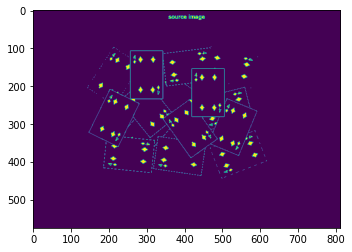

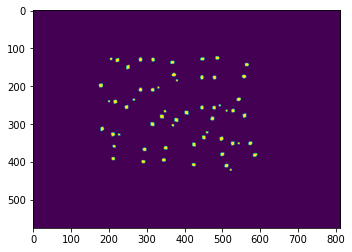

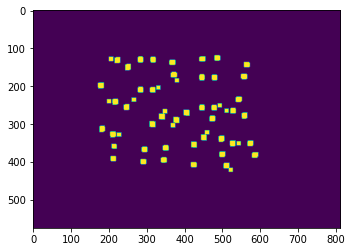

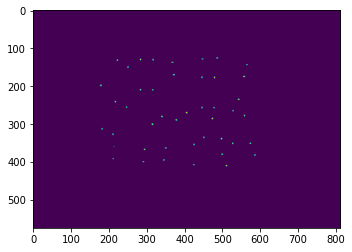

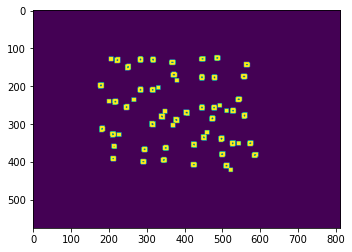

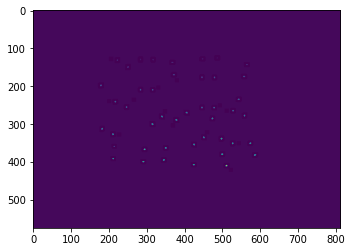

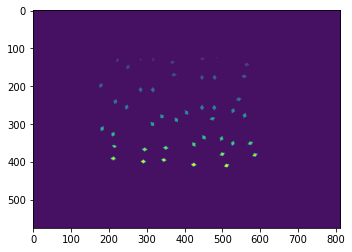

In [29]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('cards.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh)
plt.show()

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
plt.imshow(opening)
plt.show()

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
plt.imshow(sure_bg)
plt.show()

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
plt.imshow(sure_fg)
plt.show()

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown)
plt.show()

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

plt.imshow(markers)
plt.show()

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.imshow(markers)
plt.show()

In [ ]:
# import the necessary packages
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread("check.jpg")
plt.imshow(image)
plt.show()
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
# show the original image and the edge detected image
print("STEP 1: Edge Detection")
plt.imshow(image)
plt.show()
plt.imshow(edged)
plt.show()
cv2.destroyAllWindows()
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(image)
plt.show()
cv2.destroyAllWindows()
# apply the four point transform to obtain a top-down
# view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
# convert the warped image to grayscale, then threshold it
# to give it that 'black and white' paper effect
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255
# show the original and scanned images
print("STEP 3: Apply perspective transform")
plt.imshow(imutils.resize(orig, height = 650))
plt.show()
plt.imshow(imutils.resize(warped, height = 650))
plt.show()